# Отток клиентов <a id="intro"></a>

<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Описание" data-toc-modified-id="Описание-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Описание</a></span></li><li><span><a href="#Импорт-необходимых-библиотек" data-toc-modified-id="Импорт-необходимых-библиотек-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Импорт необходимых библиотек</a></span></li><li><span><a href="#Подготовка-данных" data-toc-modified-id="Подготовка-данных-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Подготовка данных</a></span></li><li><span><a href="#Исследование-задачи" data-toc-modified-id="Исследование-задачи-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Исследование задачи</a></span></li><li><span><a href="#Борьба-с-дисбалансом" data-toc-modified-id="Борьба-с-дисбалансом-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Борьба с дисбалансом</a></span></li><li><span><a href="#Тестирование-модели" data-toc-modified-id="Тестирование-модели-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Тестирование модели</a></span></li><li><span><a href="#Общие-выводы" data-toc-modified-id="Общие-выводы-7"><span class="toc-item-num">7&nbsp;&nbsp;</span>Общие выводы</a></span></li></ul></div>

## Описание

Из «Бета-Банка» стали уходить клиенты. Каждый месяц. Немного, но заметно. Банковские маркетологи посчитали: сохранять текущих клиентов дешевле, чем привлекать новых. Требуется спрогнозировать, уйдёт клиент из банка в ближайшее время или нет. На входе имеются исторические данные о поведении клиентов и расторжении договоров с банком. Необходимо построить модель с предельно большим значением F1-меры, не менее 0.59 на тестовой выборке, сравнить значение AUC-ROC с F1-мерой.

Источник данных: https://www.kaggle.com/barelydedicated/bank-customer-churn-modeling

## Импорт необходимых библиотек

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.tree import DecisionTreeClassifier 
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import recall_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import precision_score
from sklearn.metrics import f1_score
from sklearn.metrics import classification_report
from sklearn.utils import shuffle
from sklearn.metrics import roc_curve
from sklearn.metrics import precision_recall_curve
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import warnings
warnings.filterwarnings("ignore")
pd.options.mode.chained_assignment = None
pd.set_option("display.max_columns", None)

## Подготовка данных

Прочитаем информацию из файла.

In [2]:
data = pd.read_csv("Churn.csv")
data.head()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2.0,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1.0,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8.0,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1.0,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2.0,125510.82,1,1,1,79084.10,0


Приведем данные к порядку.

In [3]:
data = data.drop(["RowNumber", "CustomerId", "Surname"], axis=1)  # устраним не несущие пользу для обучения столбцы
data.columns = ["credit_score", "geography", "gender", "age", "tenure", # приведем к единому стилю название признаков для удобства
                "balance","num_of_products", "has_cr_card", 
                "is_active_member", "estimated_salary","exited"]
data["geography"] = data["geography"].str.lower() # приведем к нижнему регистру объекты признака география и гендер
data["gender"] = data["gender"].str.lower()
data = pd.get_dummies(data, drop_first=True) # получим демми-признаки
data.head()

,credit_score,age,tenure,balance,num_of_products,has_cr_card,is_active_member,estimated_salary,exited,geography_germany,geography_spain,gender_male
0,619,42,2.0,0.00,1,1,1,101348.88,1,0,0,0
1,608,41,1.0,83807.86,1,0,1,112542.58,0,0,1,0
2,502,42,8.0,159660.80,3,1,0,113931.57,1,0,0,0
3,699,39,1.0,0.00,2,0,0,93826.63,0,0,0,0
4,850,43,2.0,125510.82,1,1,1,79084.10,0,0,1,0


Признак "tenure" имеет пропуски в объектах. Отсутствие объектов в некоторых случаях обусловлено притоком новых клиентов, у которых еще не стукнул год в данном банке. Устраним их, иначе при обучении модели возникнет ошибка.

In [4]:
data["tenure"] = data["tenure"].fillna(0) # Новые клиенты

Разобъем признаки на целевой признак и все остальные признаки.

In [5]:
features = data.drop("exited", axis=1)
target = data["exited"]
print(features.shape)
print(target.shape)

(10000, 11)
(10000,)


Разобьем признаки на обучающую, валидационную, тестовую выборки.

In [6]:
features_train, features_valid, target_train, target_valid = train_test_split(features, target, test_size=0.20, random_state=12345)
features_train, features_test, target_train, target_test = train_test_split(features_train, target_train, test_size=0.25, random_state=12345)
print(features_train.shape)
print(target_train.shape)
print(features_valid.shape)
print(target_valid.shape)
print(features_test.shape)
print(target_test.shape)

(6000, 11)
(6000,)
(2000, 11)
(2000,)
(2000, 11)
(2000,)


Стандартизируем численные объекты.

In [7]:
numeric = ["credit_score", "age", "tenure", "balance", "num_of_products", "estimated_salary"]
scalar = StandardScaler()
scalar.fit(features_train[numeric])

features_train[numeric] = scalar.transform(features_train[numeric])
features_valid[numeric] = scalar.transform(features_valid[numeric])
features_test[numeric] = scalar.transform(features_test[numeric])

[В начало](#intro)

## Исследование задачи

Рассмотрим баланс классов.

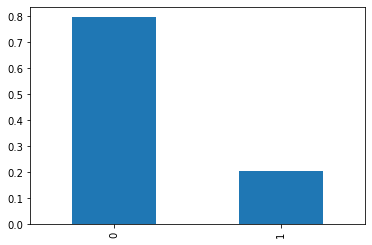

In [8]:
data["exited"].value_counts(normalize=1).plot(kind="bar")
plt.show()

Нарушен баланс классов. Доля отрицательных классов составляем почти 80%. Обучим модел без учета и с учетом имеющегося дисбаланса.

Напишем функцию, которая будет высчитывать основные метрики.

In [9]:
def other_metrics(target_valid, predicted_valid):
    accuracy = accuracy_score(target_valid, predicted_valid)
    recall = recall_score(target_valid, predicted_valid)
    precision = precision_score(target_valid, predicted_valid)
    return accuracy, recall, precision

Обучим первую модель с учетом дисбаланса и рассчитаем метрики модели.

In [10]:
tree_imbalanced_f1 = 0
best_predicted_valid = 0
tree_imbalanced = None

for depth in range(1, 10):
    model = DecisionTreeClassifier(max_depth=depth, random_state=12345)
    model.fit(features_train, target_train)
    prediction = model.predict(features_valid)
    result = f1_score(target_valid, prediction)

    if result > tree_imbalanced_f1:
        tree_imbalanced_f1 = result
        tree_imbalanced = model
        best_predicted_valid = prediction
        
print("F1-мера:", tree_imbalanced_f1)
tree_imbalanced_metrics = other_metrics(target_valid, best_predicted_valid)
print("Accuracy:", tree_imbalanced_metrics[0])
print("Полнота:", tree_imbalanced_metrics[1])
print("Точность:", tree_imbalanced_metrics[2])

F1-мера: 0.5669515669515669
Accuracy: 0.848
Полнота: 0.46604215456674475
Точность: 0.7236363636363636


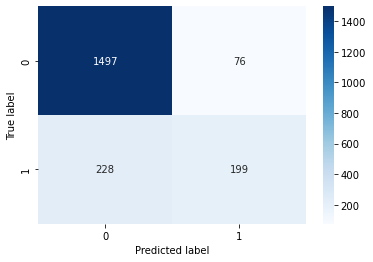

In [11]:
sns.heatmap(confusion_matrix(target_valid, 
                             best_predicted_valid), 
            annot=True, 
            fmt='d', 
            cmap="Blues")
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

In [12]:
probabilities_valid = tree_imbalanced.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]

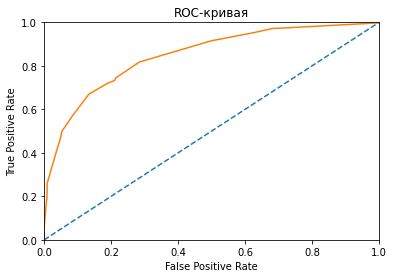

In [13]:
fpr, tpr, thresholds = roc_curve(target_valid, probabilities_one_valid)
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.plot(fpr, tpr)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC-кривая")
plt.show()

In [14]:
roc_auc_tree_imbalanced = roc_auc_score(target_valid, probabilities_one_valid)
roc_auc_tree_imbalanced

0.8483788938334392

Низкое значения показателя F1 модели дерева решений говорит о не лучшем сочетании показателей точности(Precision) и полноты(Recall), в то время как roc-auc равен ~0.85. Модель предсказывает примерно ~56% положительных ответов, достаточно низкий показатей, модель плохо предсказывает уход клиента. Точность у модели чуть выше полноты, примерно ~72% выявленных ответов являютя истинно положительными. 

In [15]:
forest_imbalanced_f1 = 0
best_predicted_valid = 0
forest_imbalanced = None

for est in range(10, 101, 10):
    for depth in range(1, 10):
        model = RandomForestClassifier(n_estimators=est, max_depth=depth, random_state=12345)
        model.fit(features_train, target_train)
        prediction = model.predict(features_valid)
        result = f1_score(target_valid, prediction) 
        
        if result > forest_imbalanced_f1:
            forest_imbalanced_f1 = result
            forest_imbalanced = model
            best_predicted_valid = prediction

print("F1-мера:", forest_imbalanced_f1)
forest_imbalanced_metrics = other_metrics(target_valid, best_predicted_valid)
print("Accuracy:", forest_imbalanced_metrics[0])
print("Полнота:", forest_imbalanced_metrics[1])
print("Точность:", forest_imbalanced_metrics[2])          

F1-мера: 0.5635528330781011
Accuracy: 0.8575
Полнота: 0.4309133489461358
Точность: 0.8141592920353983


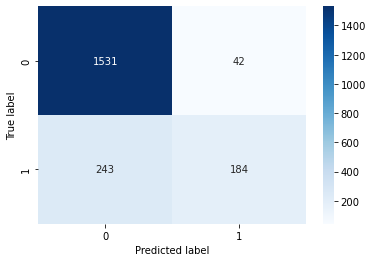

In [16]:
sns.heatmap(confusion_matrix(target_valid, 
                             best_predicted_valid), 
            annot=True, 
            fmt='d', 
            cmap="Blues")
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

In [17]:
probabilities_valid = forest_imbalanced.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]

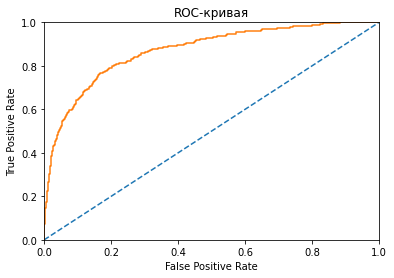

In [18]:
fpr, tpr, thresholds = roc_curve(target_valid, probabilities_one_valid)
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.plot(fpr, tpr)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC-кривая")
plt.show()

In [19]:
roc_auc_forest_imbalanced = roc_auc_score(target_valid, probabilities_one_valid)
roc_auc_forest_imbalanced

0.8704871879238496

Как и дерево решений, случайный лес имеет значение показателя F1 ~56%, roc-auc равен ~0.87. Полнота у модели ниже у дерева решений, модель предсказывает лишь ~43% ухода клиентов, но зато точность у модели высокая ~81%.

In [20]:
logistic_imbalanced_f1 = 0
best_predicted_valid = 0
logistic_imbalanced = None

for iters in (100, 10001, 100):
    model = LogisticRegression(random_state=12345, max_iter=iters)
    model.fit(features_train, target_train)
    prediction = model.predict(features_valid)
    result = f1_score(target_valid, prediction) 
    
    if result > logistic_imbalanced_f1:
        logistic_imbalanced_f1 = result
        logistic_imbalanced = model
        best_predicted_valid = prediction

print("F1-мера:", logistic_imbalanced_f1)
logistic_imbalanced_metrics = other_metrics(target_valid, best_predicted_valid)
print("Accuracy:", logistic_imbalanced_metrics[0])
print("Полнота:", logistic_imbalanced_metrics[1])
print("Точность:", logistic_imbalanced_metrics[2])

F1-мера: 0.29525483304042177
Accuracy: 0.7995
Полнота: 0.19672131147540983
Точность: 0.5915492957746479


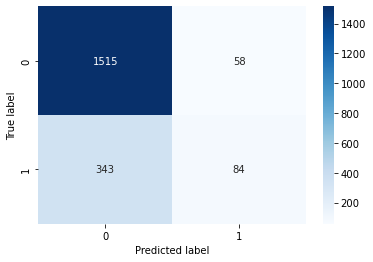

In [21]:
sns.heatmap(confusion_matrix(target_valid, 
                             best_predicted_valid), 
            annot=True, 
            fmt='d', 
            cmap="Blues")
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

In [22]:
probabilities_valid = logistic_imbalanced.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]

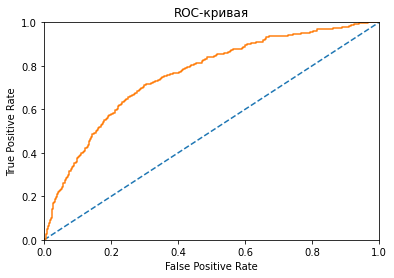

In [23]:
fpr, tpr, thresholds = roc_curve(target_valid, probabilities_one_valid)
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.plot(fpr, tpr)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC-кривая")
plt.show()

In [24]:
roc_auc_logistic_imbalanced = roc_auc_score(target_valid, probabilities_one_valid)
roc_auc_logistic_imbalanced

0.758640763111702

Все показатели модели логистической регрессии ниже двух предыдущих обученных моделей.

[В начало](#intro)

## Борьба с дисбалансом

**Дерево решений**

In [25]:
tree_balanced_f1 = 0
best_predicted_valid = 0
tree_balanced = None

for depth in range(1, 10):
    model = DecisionTreeClassifier(max_depth=depth, random_state=12345, class_weight="balanced")
    model.fit(features_train, target_train)
    prediction = model.predict(features_valid)
    result = f1_score(target_valid, prediction)

    if result > tree_balanced_f1:
        tree_balanced_f1 = result
        tree_balanced = model
        best_predicted_valid = prediction
        
print("F1-мера:", tree_balanced_f1)
tree_balanced_metrics = other_metrics(target_valid, best_predicted_valid)
print("Accuracy:", tree_balanced_metrics[0])
print("Полнота:", tree_balanced_metrics[1])
print("Точность:", tree_balanced_metrics[2])

F1-мера: 0.5933852140077821
Accuracy: 0.791
Полнота: 0.7142857142857143
Точность: 0.5074875207986689


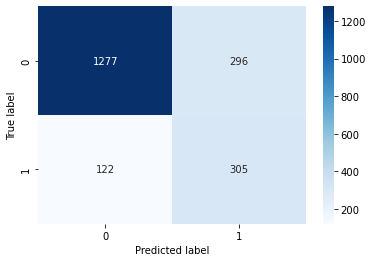

In [26]:
sns.heatmap(confusion_matrix(target_valid, 
                             best_predicted_valid), 
            annot=True, 
            fmt='d', 
            cmap="Blues")
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

In [27]:
probabilities_valid = tree_balanced.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]

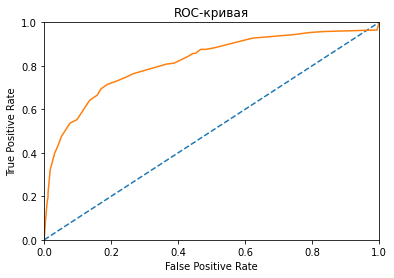

In [28]:
fpr, tpr, thresholds = roc_curve(target_valid, probabilities_one_valid)
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.plot(fpr, tpr)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC-кривая")
plt.show()

In [29]:
roc_auc_tree_balanced = roc_auc_score(target_valid, probabilities_one_valid)
roc_auc_tree_balanced

0.8180962107936771

Сбалансированная модель дерева решений имеет значение показатели F1 чуть лучше своего предшественника, соблюдается чуть лучшая балансировка между показателями полноты и точности. Полнота со сравнению улучшилась, точность подсбавилась, также подсбавилось значение roc-auc.

**Случайный лес**

In [30]:
forest_balanced_f1 = 0
best_predicted_valid = 0
forest_balanced = None

for est in range(10, 101, 10):
    for depth in range(1, 10):
        model = RandomForestClassifier(n_estimators=est, max_depth=depth, random_state=12345, class_weight="balanced")
        model.fit(features_train, target_train)
        prediction = model.predict(features_valid)
        result = f1_score(target_valid, prediction) 
        
        if result > forest_balanced_f1:
            forest_balanced_f1 = result
            forest_balanced = model
            best_predicted_valid = prediction

print("F1-мера:", forest_balanced_f1)
forest_balanced_metrics = other_metrics(target_valid, best_predicted_valid)
print("Accuracy:", forest_balanced_metrics[0])
print("Полнота:", forest_balanced_metrics[1])
print("Точность:", forest_balanced_metrics[2])

F1-мера: 0.6545454545454545
Accuracy: 0.8385
Полнота: 0.7166276346604216
Точность: 0.6023622047244095


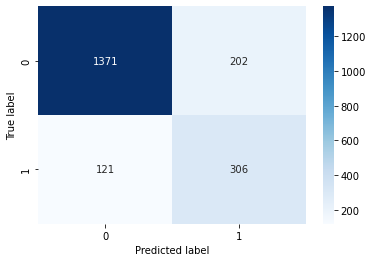

In [31]:
sns.heatmap(confusion_matrix(target_valid, 
                             best_predicted_valid), 
            annot=True, 
            fmt='d', 
            cmap="Blues")
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

In [32]:
probabilities_valid = forest_balanced.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]

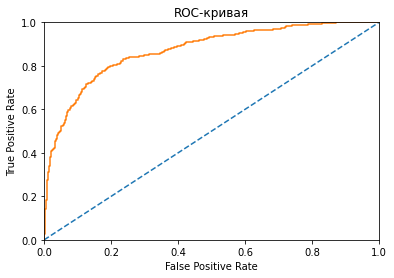

In [33]:
fpr, tpr, thresholds = roc_curve(target_valid, probabilities_one_valid)
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.plot(fpr, tpr)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC-кривая")
plt.show()

In [34]:
roc_auc_forest_balanced = roc_auc_score(target_valid, probabilities_one_valid)
roc_auc_forest_balanced

0.8709606340008724

Сбалансированная модель случайного леса выдает высокие значения показателей по сравнению с остальными моделями, наблюдается наилучший F1, благодаря высоким показателям точности и полноты, их лучшему сочетанию, с 70% предсказывает положительные ответы из которых 60% действительно положительные. Показатель roc-auc 0.87 - самый высокий.

**Логистическая регресиия**

In [35]:
logistic_balanced_f1 = 0
best_predicted_valid = 0
logistic_balanced = None

for iters in (100, 10001, 100):
    model = LogisticRegression(random_state=12345, max_iter=iters, class_weight="balanced")
    model.fit(features_train, target_train)
    prediction = model.predict(features_valid)
    result = f1_score(target_valid, prediction) 
    
    if result > logistic_balanced_f1:
        logistic_balanced_f1 = result
        logistic_balanced = model
        best_predicted_valid = prediction

print("F1-мера:", logistic_balanced_f1)
logistic_balanced_metrics = other_metrics(target_valid, best_predicted_valid)
print("Accuracy:", logistic_balanced_metrics[0])
print("Полнота:", logistic_balanced_metrics[1])
print("Точность:", logistic_balanced_metrics[2])

F1-мера: 0.5025295109612141
Accuracy: 0.705
Полнота: 0.6978922716627635
Точность: 0.3926218708827404


In [36]:
probabilities_valid = logistic_balanced.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]

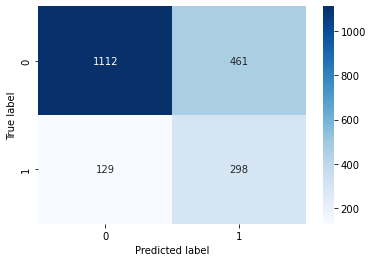

In [37]:
sns.heatmap(confusion_matrix(target_valid, 
                             best_predicted_valid), 
            annot=True, 
            fmt='d', 
            cmap="Blues")
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

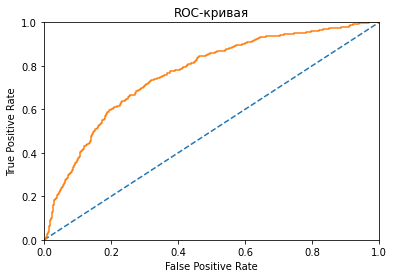

In [38]:
fpr, tpr, thresholds = roc_curve(target_valid, probabilities_one_valid)
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.plot(fpr, tpr)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC-кривая")
plt.show()

In [39]:
roc_auc_logistic_balanced = roc_auc_score(target_valid, probabilities_one_valid)
roc_auc_logistic_balanced

0.7644174007810371

Сбалансированная модель логистической регресии лучше своего предшественника, однако значения метрик все еще самые низкие.

Попробуем еще один способ устранения дисбаланса.

In [40]:
# Разделим признаки и целевой признак по единице и нулям из целевого признака
def upsample(features, target, repeat):
    
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]
    
    features_upsampled = pd.concat([features_zeros] + [features_ones] * repeat)
    target_upsampled = pd.concat([target_zeros] + [target_ones] * repeat)
    
    features_upsampled = shuffle(features_upsampled, random_state=12345)
    target_upsampled = shuffle(target_upsampled, random_state=12345)
    
    return features_upsampled, target_upsampled

In [41]:
# Повысим веса положительных объектов
features_upsampled, target_upsampled = upsample(features_train, target_train, 4)

In [42]:
def dowm_sample(features, target, fraction):
    
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]
    
    features_downsampled = pd.concat([features_ones] + [features_zeros.sample(frac=fraction, random_state=12345)])
    target_downsampled = pd.concat([target_ones] + [target_zeros.sample(frac=fraction, random_state=12345)])
    
    features_downsampled = shuffle(features_downsampled, random_state=12345)
    target_downsampled = shuffle(target_downsampled, random_state=12345)
    
    return features_downsampled, target_downsampled

In [43]:
# Снизим долю отрицательных значений
features_downsampled, target_downsampled = dowm_sample(features_train, target_train, 0.25)

In [44]:
print(features_downsampled[target_train==0].shape)
print(features_downsampled[target_train==1].shape)

(1195, 11)
(1219, 11)


Классов в обучающей выборке примерно поровну, попробуем построить модели.

**Дерево решений**

In [45]:
tree_f1 = 0
best_predicted_valid = 0
tree = None

for depth in range(1, 10):
    model = DecisionTreeClassifier(max_depth=depth, random_state=12345)
    model.fit(features_downsampled, target_downsampled)
    prediction = model.predict(features_valid)
    result = f1_score(target_valid, prediction)

    if result > tree_f1:
        tree_f1 = result
        tree = model
        best_predicted_valid = prediction
        
print("F1-мера:", tree_f1)
tree_metrics = other_metrics(target_valid, best_predicted_valid)
print("Accuracy:", tree_metrics[0])
print("Полнота:", tree_metrics[1])
print("Точность:", tree_metrics[2])

F1-мера: 0.582210242587601
Accuracy: 0.7675
Полнота: 0.7587822014051522
Точность: 0.47230320699708456


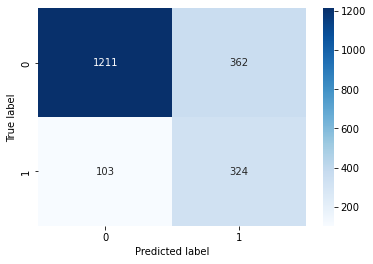

In [46]:
sns.heatmap(confusion_matrix(target_valid, 
                             best_predicted_valid), 
            annot=True, 
            fmt='d', 
            cmap="Blues")
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

In [47]:
probabilities_valid = tree.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]

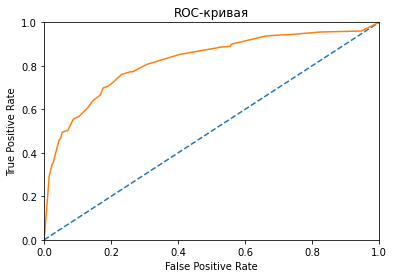

In [48]:
fpr, tpr, thresholds = roc_curve(target_valid, probabilities_one_valid)
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.plot(fpr, tpr)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC-кривая")
plt.show()

In [49]:
roc_auc_tree = roc_auc_score(target_valid, probabilities_one_valid)
roc_auc_tree

0.8218889902943554

Значения показателей незначительно ниже при upsampling/downsampling, чем при настройке гиперпараметра class_weight, но почти в той же степени выше аналогичной несбалансированной модели.

In [50]:
forest_f1 = 0
best_predicted_valid = 0
forest = None

for est in range(10, 101, 10):
    for depth in range(1, 10):
        model = RandomForestClassifier(n_estimators=est, max_depth=depth, random_state=12345)
        model.fit(features_downsampled, target_downsampled)
        prediction = model.predict(features_valid)
        result = f1_score(target_valid, prediction) 
        
        if result > forest_f1:
            forest_f1 = result
            forest = model
            best_predicted_valid = prediction

print("F1-мера:", forest_f1)
forest_metrics = other_metrics(target_valid, best_predicted_valid)
print("Accuracy:", forest_metrics[0])
print("Полнота:", forest_metrics[1])
print("Точность:", forest_metrics[2])

F1-мера: 0.626641651031895
Accuracy: 0.801
Полнота: 0.7822014051522248
Точность: 0.5226917057902973


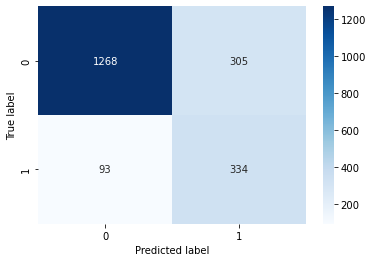

In [51]:
sns.heatmap(confusion_matrix(target_valid, 
                             best_predicted_valid), 
            annot=True, 
            fmt='d', 
            cmap="Blues")
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

In [52]:
probabilities_valid = forest.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]

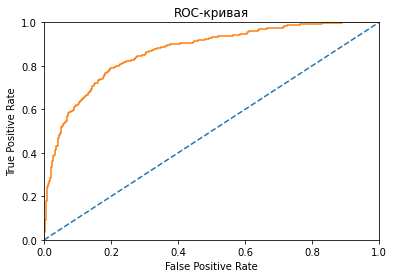

In [53]:
fpr, tpr, thresholds = roc_curve(target_valid, probabilities_one_valid)
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.plot(fpr, tpr)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC-кривая")
plt.show()

In [54]:
roc_auc_forest = roc_auc_score(target_valid, probabilities_one_valid)
roc_auc_forest

0.8663021032618649

Значение метрик для случайного леса выше при настройке гиперпараметра class_weight.

In [55]:
logistic_f1 = 0
best_predicted_valid = 0
logistic = None

for iters in (100, 10001, 100):
    model = LogisticRegression(random_state=12345, max_iter=iters)
    model.fit(features_downsampled, target_downsampled)
    prediction = model.predict(features_valid)
    result = f1_score(target_valid, prediction) 
    
    if result > logistic_f1:
        logistic_f1 = result
        logistic = model
        best_predicted_valid = prediction

print("F1-мера:", logistic_f1)
logistic_metrics = other_metrics(target_valid, best_predicted_valid)
print("Accuracy:", logistic_metrics[0])
print("Полнота:", logistic_metrics[1])
print("Точность:", logistic_metrics[2])

F1-мера: 0.501248959200666
Accuracy: 0.7005
Полнота: 0.7049180327868853
Точность: 0.3888888888888889


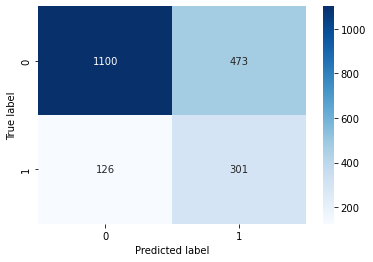

In [56]:
sns.heatmap(confusion_matrix(target_valid, 
                             best_predicted_valid), 
            annot=True, 
            fmt='d', 
            cmap="Blues")
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

In [57]:
probabilities_valid = logistic.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]

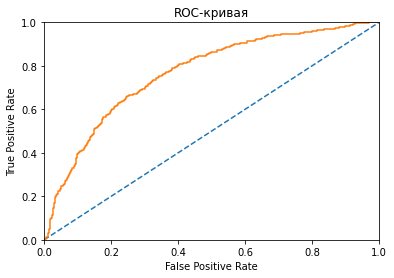

In [58]:
fpr, tpr, thresholds = roc_curve(target_valid, probabilities_one_valid)
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.plot(fpr, tpr)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC-кривая")
plt.show()

In [59]:
roc_auc_logistic = roc_auc_score(target_valid, probabilities_one_valid)
roc_auc_logistic

0.7670541083357776

Практически идентичные значения при upsampling/downsampling и при настройке гиперпараметра class_weight у логистической регрессии.

Выведем результаты всех моделей.

**Дерево решений**

*Несбалансированная*

In [60]:
print("F1-мера:", tree_imbalanced_f1)
print("Accuracy:", tree_imbalanced_metrics[0])
print("Полнота:", tree_imbalanced_metrics[1])
print("Точность:", tree_imbalanced_metrics[2])
print("ROC_AUC:", roc_auc_tree_imbalanced)

F1-мера: 0.5669515669515669
Accuracy: 0.848
Полнота: 0.46604215456674475
Точность: 0.7236363636363636
ROC_AUC: 0.8483788938334392


*Сбалансированная гиперпараметром class_weight="balanced"*

In [61]:
print("F1-мера:", tree_balanced_f1)
print("Accuracy:", tree_balanced_metrics[0])
print("Полнота:", tree_balanced_metrics[1])
print("Точность:", tree_balanced_metrics[2])
print("ROC_AUC:", roc_auc_tree_balanced)

F1-мера: 0.5933852140077821
Accuracy: 0.791
Полнота: 0.7142857142857143
Точность: 0.5074875207986689
ROC_AUC: 0.8180962107936771


*Сбалансированная применением upsampling/downsampling*

In [62]:
print("F1-мера:", tree_f1)
print("Accuracy:", tree_metrics[0])
print("Полнота:", tree_metrics[1])
print("Точность:", tree_metrics[2])
print("ROC_AUC:", roc_auc_tree)

F1-мера: 0.582210242587601
Accuracy: 0.7675
Полнота: 0.7587822014051522
Точность: 0.47230320699708456
ROC_AUC: 0.8218889902943554


**Случайный лес**

*Несбалансированная*

In [63]:
print("F1-мера:", forest_imbalanced_f1)
print("Accuracy:", forest_imbalanced_metrics[0])
print("Полнота:", forest_imbalanced_metrics[1])
print("Точность:", forest_imbalanced_metrics[2])
print("ROC_AUC:", roc_auc_forest_imbalanced)

F1-мера: 0.5635528330781011
Accuracy: 0.8575
Полнота: 0.4309133489461358
Точность: 0.8141592920353983
ROC_AUC: 0.8704871879238496


*Сбалансированная гиперпараметром class_weight="balanced"*

In [64]:
print("F1-мера:", forest_balanced_f1)
print("Accuracy:", forest_balanced_metrics[0])
print("Полнота:", forest_balanced_metrics[1])
print("Точность:", forest_balanced_metrics[2])
print("ROC_AUC:", roc_auc_forest_balanced)

F1-мера: 0.6545454545454545
Accuracy: 0.8385
Полнота: 0.7166276346604216
Точность: 0.6023622047244095
ROC_AUC: 0.8709606340008724


*Сбалансированная применением upsampling/downsampling*

In [65]:
print("F1-мера:", forest_f1)
print("Accuracy:", forest_metrics[0])
print("Полнота:", forest_metrics[1])
print("Точность:", forest_metrics[2])
print("ROC_AUC:", roc_auc_forest)

F1-мера: 0.626641651031895
Accuracy: 0.801
Полнота: 0.7822014051522248
Точность: 0.5226917057902973
ROC_AUC: 0.8663021032618649


**Логистическая регресия**

*Несбалансированная*

In [66]:
print("F1-мера:", logistic_imbalanced_f1)
print("Accuracy:", logistic_imbalanced_metrics[0])
print("Полнота:", logistic_imbalanced_metrics[1])
print("Точность:", logistic_imbalanced_metrics[2])
print("ROC_AUC:", roc_auc_logistic_imbalanced)

F1-мера: 0.29525483304042177
Accuracy: 0.7995
Полнота: 0.19672131147540983
Точность: 0.5915492957746479
ROC_AUC: 0.758640763111702


*Сбалансированная гиперпараметром class_weight="balanced"*

In [67]:
print("F1-мера:", logistic_balanced_f1)
print("Accuracy:", logistic_balanced_metrics[0])
print("Полнота:", logistic_balanced_metrics[1])
print("Точность:", logistic_balanced_metrics[2])
print("ROC_AUC:", roc_auc_logistic_balanced)

F1-мера: 0.5025295109612141
Accuracy: 0.705
Полнота: 0.6978922716627635
Точность: 0.3926218708827404
ROC_AUC: 0.7644174007810371


*Сбалансированная применением upsampling/downsampling*

In [68]:
print("F1-мера:", logistic_f1)
print("Accuracy:", logistic_metrics[0])
print("Полнота:", logistic_metrics[1])
print("Точность:", logistic_metrics[2])
print("ROC_AUC:", roc_auc_logistic)

F1-мера: 0.501248959200666
Accuracy: 0.7005
Полнота: 0.7049180327868853
Точность: 0.3888888888888889
ROC_AUC: 0.7670541083357776


Таким образом, остановимся на модели случайного леса с настройкой гиперпараметра class_weight, у которой показатели дали наилучшие результаты на валидационной выборке.

Метрики:

`F1-мера:` 0.6545454545454545

`Accuracy:` 0.8385

`Полнота:` 0.7166276346604216

`Точность:` 0.6023622047244095

`ROC_AUC:` 0.8710142316699694

Гиперпараметры модели:

`class_weight:` balanced

`max_depth:` 8

`n_estimators:` 100

[В начало](#intro)

## Тестирование модели

Для более точного предсказания увеличим тестовую выборку. Соотношение обучающей и тестовой выборки будет 3:2. 

In [70]:
features_test = pd.concat([features_test]+[features_valid])
target_test = pd.concat([target_test]+[target_valid])

Обучим модель с лучшими гиперпараметрами и расчитаем метрики.

In [71]:
forest_balanced = RandomForestClassifier(n_estimators=100, max_depth=8, random_state=12345, class_weight="balanced")
forest_balanced.fit(features_train, target_train)
predicted_test = forest_balanced.predict(features_test)
forest_balanced_test_f1 = f1_score(target_test, predicted_test) 

print("F1-мера:", forest_balanced_test_f1)
forest_balanced_test_metrics = other_metrics(target_test, predicted_test)
print("Accuracy:", forest_balanced_test_metrics[0])
print("Полнота:", forest_balanced_test_metrics[1])
print("Точность:", forest_balanced_test_metrics[2])

F1-мера: 0.6188091263216472
Accuracy: 0.82875
Полнота: 0.6797066014669927
Точность: 0.567926455566905


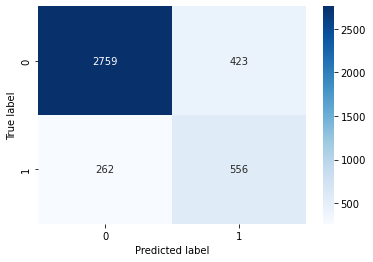

In [72]:
sns.heatmap(confusion_matrix(target_test, 
                             predicted_test), 
            annot=True, 
            fmt='d', 
            cmap="Blues")
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

In [73]:
probabilities_valid = forest_balanced.predict_proba(features_test)
probabilities_one_valid = probabilities_valid[:, 1]

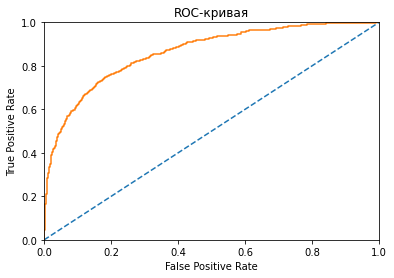

In [74]:
fpr, tpr, thresholds = roc_curve(target_test, probabilities_one_valid)
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.plot(fpr, tpr)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC-кривая")
plt.show()

In [75]:
roc_auc_forest_balanced_test = roc_auc_score(target_test, probabilities_one_valid)
roc_auc_forest_balanced_test

0.8623622485281666

Сбалансированная модель случайного леса на тестовой выборке выдала F1 ~0.62, что выше порогового значения - 0.59.

Проверим модель на адекватность.

In [76]:
constant_prediction = pd.Series([0]*len(target_test))
print("F1-мера:", f1_score(target_test, constant_prediction))
print("Accuracy:", other_metrics(target_test, constant_prediction)[0])
print("ROC-AUC:", roc_auc_score(target_test, constant_prediction))
print("Полнота:", other_metrics(target_test, constant_prediction)[1])
print("Точность:", other_metrics(target_test, constant_prediction)[2])

F1-мера: 0.0
Accuracy: 0.7955
ROC-AUC: 0.5
Полнота: 0.0
Точность: 0.0


Модель прошла проверку на адекватность.

[В начало](#intro)

## Общие выводы

Лучшая модель RandomForestClassifie со следующими гиперпараметры модели: 

`class_weight:` balanced

`max_depth:` 8

`n_estimators:` 100

На тестовой выборке метрики модели следующие:

`F1-мера:` 0.6188091263216472

`Accuracy:` 0.82875

`Полнота:` 0.6797066014669927

`Точность:` 0.567926455566905

[В начало](#intro)